### Lemon quality detection

In [2]:
# Import libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
image_size = 300
batch_size = 32

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    seed = 123,
    shuffle = True,
    batch_size=batch_size,
    image_size=(image_size, image_size),
)

Found 2528 files belonging to 3 classes.


In [5]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [6]:
class_names = dataset.class_names

In [7]:
class_names

['bad_quality', 'empty_background', 'good_quality']

In [9]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch)

(32, 300, 300, 3)
tf.Tensor([0 0 2 2 2 1 0 2 1 0 2 2 2 0 2 2 2 2 0 2 0 1 2 2 2 1 2 2 2 2 0 2], shape=(32,), dtype=int32)


In [10]:
len(dataset)

79

In [11]:
79*32

2528

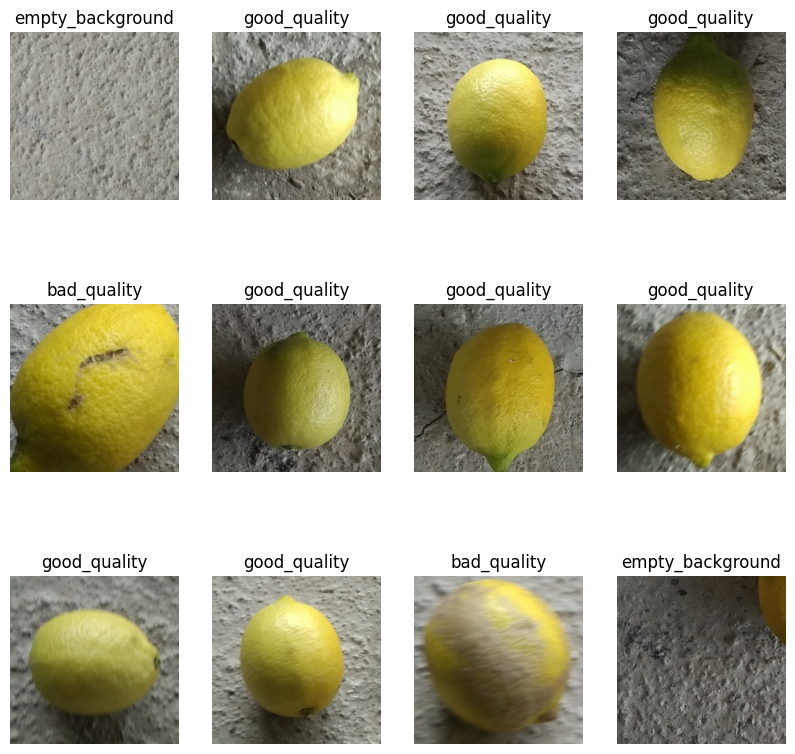

In [12]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [13]:
# split the dataset into train test validation

In [14]:
len(dataset)

79

In [15]:
# traning
79*0.8

63.2

In [16]:
100 - 63.2

36.8

In [17]:
len(dataset.take(63))

63

In [18]:
def split_dataset(dataset, train_split= 0.8, test_split = 0.1, val_split=0.1, shuffle=True, shuffle_size = 10000):
    assert (train_split+test_split+val_split) == 1
    
    ds_size = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
        
    train_size = int(ds_size*train_split)
    val_size = int(ds_size * val_split)
    
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size).skip(val_size)
    
    return train_ds, test_ds, val_ds

In [19]:
train_ds, test_ds, val_ds = split_dataset(dataset)

In [20]:
len(train_ds)

63

In [21]:
len(test_ds)

9

In [22]:
len(val_ds)

7

In [23]:
# cache, shuffle, prefetch the dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [24]:
# model building


In [31]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(image_size, image_size),
    layers.Rescaling(1./299),
])

In [32]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [33]:
# apply data augmentation in train_ds

In [34]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [35]:
# model architecture

In [36]:
channel = 3
n_classes = 3

In [37]:
input_shape = (batch_size, image_size, image_size, channel)

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


C:\jay\Important Files\Lemon quality detection\lemonenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [38]:
model.build(input_shape = input_shape)

In [39]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 300, 300, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 298, 298, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 149, 149, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 147, 147, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 73, 73, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 71, 71, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 35, 35, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 33, 33, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 16, 16, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 14, 14, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 7, 7, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 5, 5, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# compile our model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [41]:
history = model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.5633 - loss: 0.8098 - val_accuracy: 0.8616 - val_loss: 0.3449
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.8216 - loss: 0.4067 - val_accuracy: 0.8527 - val_loss: 0.3487
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.8611 - loss: 0.3438 - val_accuracy: 0.9196 - val_loss: 0.2492
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.8869 - loss: 0.2720 - val_accuracy: 0.8527 - val_loss: 0.3536
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.8643 - loss: 0.3165 - val_accuracy: 0.9286 - val_loss: 0.1815
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.9425 - loss: 0.1369 - val_accuracy: 0.9688 - val_loss: 0.0718
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.9611 - loss: 0.1088 - val_accuracy: 0.9509 - val_loss: 0.1523
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.9435 - loss: 0.1483 - val_accuracy: 0.9688 - v

In [42]:
scores = model.evaluate(test_ds)

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 475ms/step - accuracy: 0.9985 - loss: 0.0129


In [43]:
scores

[0.019187167286872864, 0.9965277910232544]

In [44]:
history

In [45]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 63}

In [46]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [48]:
epochs = 30

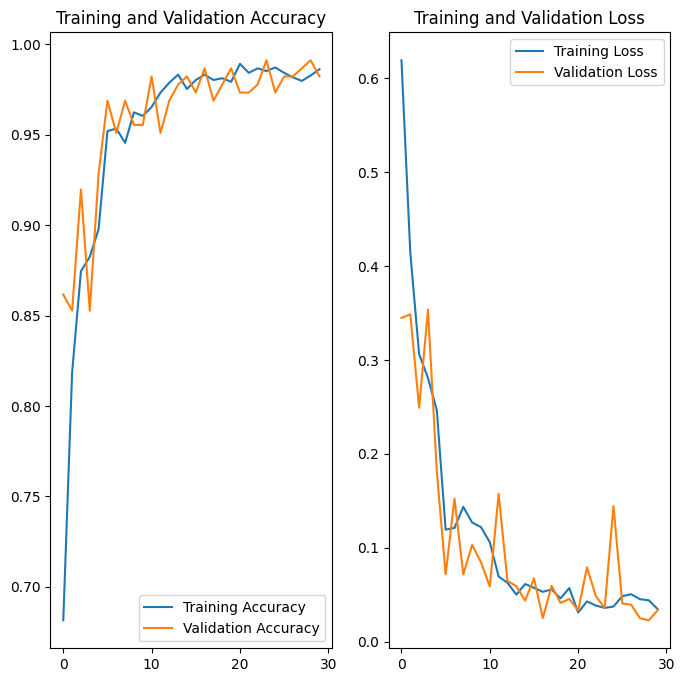

In [49]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [50]:
# prediction
import numpy as np

first image to predict
actual label bad_quality
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
predicted label bad_quality


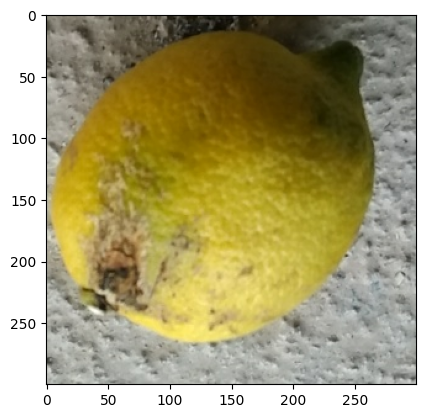

In [51]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[2].numpy().astype('uint8')
    first_label = labels_batch[2].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label", class_names[np.argmax(batch_prediction[2])])

In [52]:
# save model

In [54]:
model.save("lemon.h5")